In [6]:
# PLease note that the following code was designed to run as a Google Colab and that
#   the data are loaded from a Google Drive
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler



if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

print(f"Your version of Pytorch is {torch.__version__}. You should use a version >0.4.")



from google.colab import drive
drive.mount('/content/gdrive/')

cuda
Your version of Pytorch is 1.0.1.post2. You should use a version >0.4.
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
# Few lines to unzip data on Google Drive
with zipfile.ZipFile('../content/gdrive/My Drive/Colab Notebooks/IFT6135/trainset/Cat.zip') as z:
  z.extractall()
with zipfile.ZipFile('../content/gdrive/My Drive/Colab Notebooks/IFT6135/trainset/Dog.zip') as z:
  z.extractall()

In [0]:
# Files were located on Gdrive in order to use Google Colab
transform_DogCat = transforms.Compose([
    # you can add other transformations in this list  
#    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_DogCat_train = transforms.Compose([
    # you can add other transformations in this list  
#    transforms.Grayscale(),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])
trainingData = torchvision.datasets.ImageFolder(root="../content/gdrive/My Drive/Colab Notebooks/trainset/",transform=transform_DogCat_train) #folder trainset is in same folder as main
                                                             # cat class label is 0, dog is 1
testData =  torchvision.datasets.ImageFolder(root="../content/gdrive/My Drive/Colab Notebooks/testset/testset/",transform=transform_DogCat)

train_range = list(range(9000))+list(range(9999,18999))
valid_range = list(range(9000,9999))+list(range(18999,19998))
trainset = torch.utils.data.Subset(trainingData,train_range)
validset = torch.utils.data.Subset(trainingData,valid_range)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=25, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=54, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testData, batch_size=50, shuffle=False, num_workers=2)

In [0]:
# Voici le réseaux CNN, il contient six couches de convolution et deux couches complètement connectés
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.reconv1 = nn.Conv2d(32, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.reconv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 6)
#        self.reconv3 = nn.Conv2d(128, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 2)
#        self.reconv4 = nn.Conv2d(256, 256, 2)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256*1*1, 128)
#        self.fc2 = nn.Linear(512,128 )
        self.fc3 = nn.Linear(128, 2)
        self.dropp=0.4

    def drop(self, x):    # Notre propre fonction dropout 
        return x.mul((torch.rand_like(x)>self.dropp).type_as(x))

    def forward(self, x):
        x= F.relu(self.conv1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.reconv1(x)), (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.reconv2(x)), 2)
#        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(F.relu(self.conv3(x)), 2)
#        x = F.relu(self.conv4(x))
        x = F.avg_pool2d(F.relu(self.conv4(x)), 2)
        
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
#        x = F.relu(self.fc2(x))
        if self.training == True:
            x = self.drop(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [0]:
clf = Net()
if cuda_available:
    clf = clf.cuda()
optimizer = optim.SGD(clf.parameters(), lr=0.25)
criterion = nn.CrossEntropyLoss()
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

In [18]:
best = 0
lr_t = 0.44

loss_trainset=[]
loss_vset=[]
train_perf=[]
valid_perf=[]

for epoch in range(35):
    losses = []
    losses_val=[]
    lr_t= lr_t/(1.06)
    optimizer = optim.SGD(clf.parameters(), lr=lr_t)
    
    total_t = 0
    correct_t = 0
    # Train
    for batch_idx, data in enumerate(train_loader):
        inputs, targets = data
#        inputs=inputs.type(torch.cuda.FloatTensor)
#        targets=targets.type(torch.cuda.LongTensor)
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
        
        _, predicted = torch.max(outputs.data, 1)
        total_t += targets.size(0)
        correct_t += predicted.eq(targets.data).cpu().sum()
        
        
        if batch_idx%50==0:
            print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
            
    loss_trainset.append(np.mean(losses))
    
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        loss_val = criterion(outputs, targets)
        losses_val.append(loss_val.data.item())
    
    loss_vset.append(np.mean(losses_val))
    if correct>best :
      best_params = clf.state_dict()
      best = correct
    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    train_perf.append(100.*correct_t/total_t)
    valid_perf.append(100.*correct/total)
    clf.train()

Epoch : 0 Loss : 0.640 
Epoch : 0 Loss : 0.656 
Epoch : 0 Loss : 0.656 
Epoch : 0 Loss : 0.654 
Epoch : 0 Loss : 0.652 
Epoch : 0 Loss : 0.651 
Epoch : 0 Loss : 0.650 
Epoch : 0 Loss : 0.651 
Epoch : 0 Loss : 0.651 
Epoch : 0 Loss : 0.652 
Epoch : 0 Loss : 0.650 
Epoch : 0 Loss : 0.649 
Epoch : 0 Loss : 0.649 
Epoch : 0 Loss : 0.649 
Epoch : 0 Loss : 0.647 
Epoch : 0 Test Acc : 67.000
--------------------------------------------------------------
Epoch : 1 Loss : 0.440 
Epoch : 1 Loss : 0.607 
Epoch : 1 Loss : 0.620 
Epoch : 1 Loss : 0.624 
Epoch : 1 Loss : 0.627 
Epoch : 1 Loss : 0.627 
Epoch : 1 Loss : 0.625 
Epoch : 1 Loss : 0.622 
Epoch : 1 Loss : 0.622 
Epoch : 1 Loss : 0.621 
Epoch : 1 Loss : 0.623 
Epoch : 1 Loss : 0.622 
Epoch : 1 Loss : 0.621 
Epoch : 1 Loss : 0.619 
Epoch : 1 Loss : 0.618 
Epoch : 1 Test Acc : 65.000
--------------------------------------------------------------
Epoch : 2 Loss : 0.462 
Epoch : 2 Loss : 0.605 
Epoch : 2 Loss : 0.595 
Epoch : 2 Loss : 0.591 
Ep

In [0]:
clf.load_state_dict(best_params)
answ = np.zeros((4999,2))
#Lets' make prediction
 # Evaluate
dataiter = iter(test_loader)
k=50
clf.eval()
for i in range(0,4999,50):
  inputs, targets = dataiter.next()
  #print(type(inputs))
  if cuda_available:
    inputs, targets = inputs.cuda(),targets.cuda()

  outputs = clf(inputs)
  _, predicted = torch.max(outputs.data, 1)
  
#  print(testData.imgs[i][0][64:-4])
#  print(int(predicted.item()))
  if i==4950 : k=49
  for j in range(k):
    answ[i+j]=[int(testData.imgs[i+j][0][64:-4]),int(predicted[j].item())]
#  if i>10: break

clf.train()
print("Done")

Done


In [0]:
from google.colab import files
import pandas as pd

#answ[answ[:,0].argsort()]
#print(answ)
d1 = pd.DataFrame(answ[:,0]).astype(int)
d2 = pd.DataFrame(answ[:,1])
#print(d1)
#print(d2)
def mmap(x):
  if x==0: return "Cat"
  else : return "Dog"

d2=d2.applymap(mmap)

submission = pd.DataFrame({'id':d1[0],'label':d2[0]})
trans_dict = dict([(0,"Cat"),(1,"Dog")])
submission=submission.sort_values(by=['id'])
submission.head()

filename = 'subm.csv'
submission.to_csv(filename,index=False)

files.download('subm.csv')

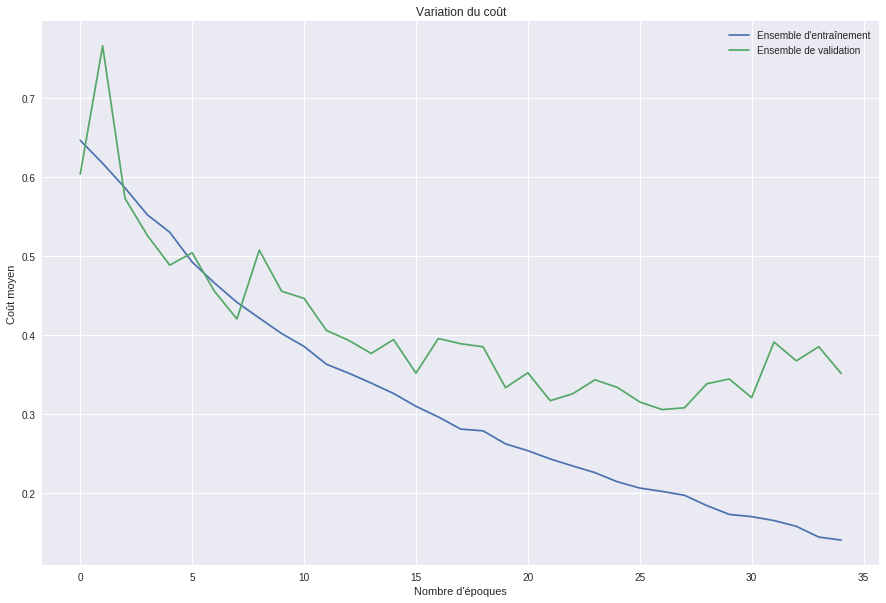

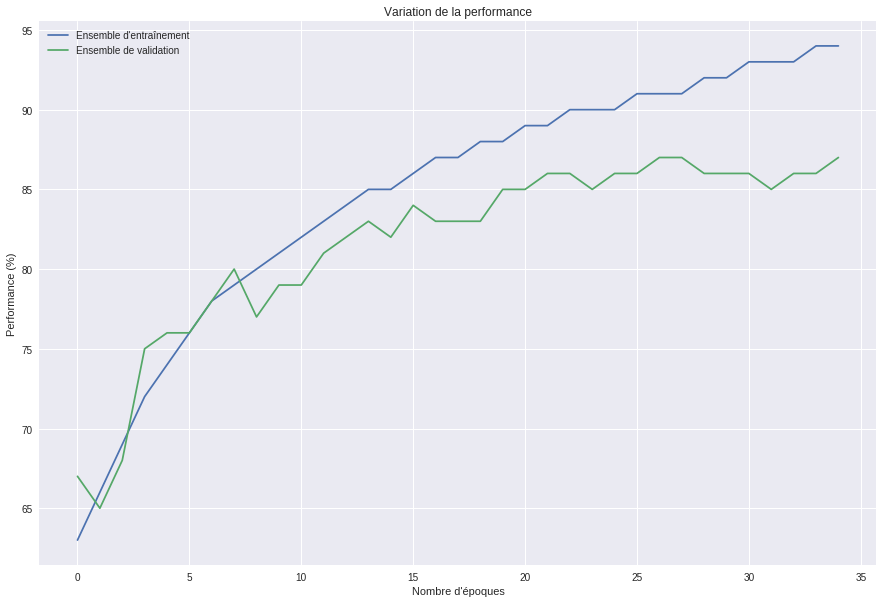

In [25]:
#loss_trainset
#loss_vset
#train_perf
#valid_perf

plt.figure(1,figsize=(15,10))
plt.plot(range(35),loss_trainset,label="Ensemble d'entraînement")
plt.plot(range(35),loss_vset,label="Ensemble de validation")
plt.xlabel("Nombre d'époques")
plt.ylabel("Coût moyen")
plt.title("Variation du coût")
plt.legend()
plt.show()

plt.figure(2,figsize=(15,10))
plt.plot(range(35),train_perf,label="Ensemble d'entraînement")
plt.plot(range(35),valid_perf,label="Ensemble de validation")
plt.xlabel("Nombre d'époques")
plt.ylabel("Performance (%)")
plt.title("Variation de la performance")
plt.legend()
plt.show()